In [1]:
from sentCount import sentCounter,posMap
from sqlite_db import thesisDB
import re
import pandas as pd

dbAddress = 'D:/Thesis/data.db'
db = thesisDB(dbAddress)

input_df = 'D:/Thesis/jsons/totaal.json.gz'
output_df = 'D:/Thesis/Sentiment/totaal_count.json.gz'

c = sentCounter()

eu_terms = ['europees unie',
     'europees parlement',
     'eurocommissaris',
     'Eurocommissaris',
     'europees commissie',
     ' eu[ -]',
     'europees gemeenschap',
     'europarlement',
     'verdrag van maastricht',
     'Europese Grondwet',
     'verdrag van lissabon',
     'lidstaat',
     ' eg[ -]',
     'economisch en monetair unie',
     'emu',
     'europees Verkiezing',
     'euroland',
     'europees project',
     'gemeenschappelijk buitenlands en veiligheidsbeleid',
     'gbvb',
     'europees Raad',
     'europees defensieagentschap']
eu_pattern = re.compile('|'.join(eu_terms))

In [7]:
###WITH FILTER
toks = db.getTokens(returnColumns = ['lemma','pos','docid','paragraph_no'])

current_paragraph = 1
current_doc = 1
text = []
paragraph = []
counts = dict()
for lemma,pos,docid,paragraph_no in toks:
    if current_doc != docid: #End of doc reached
        if re.search(eu_pattern,' '.join([lemma for lemma,pos in paragraph])) is not None:
            text += paragraph
        counts[current_doc] = c.count(text)
        current_doc = docid
        paragraph = []
        text = []
    if current_paragraph != paragraph_no:
        if re.search(eu_pattern,' '.join([lemma for lemma,pos in paragraph])) is not None:
            text += paragraph
        paragraph = []
        current_paragraph = paragraph_no
    paragraph.append((lemma.lower(),posMap[pos]))

if re.search(eu_pattern,' '.join([lemma for lemma,pos in paragraph])) is not None:
    text += paragraph
counts[current_doc] = c.count(text)
toks.close()

In [87]:
###WITHOUT FILTER
toks = db.getTokens(returnColumns = ['lemma','pos','docid','paragraph_no'])

current_paragraph = 1
current_doc = 1
text = []
paragraph = []
counts = dict()
for lemma,pos,docid,paragraph_no in toks:
    if current_doc != docid: #End of doc reached
        text += paragraph
        counts[current_doc] = c.count(text)
        current_doc = docid
        paragraph = []
        text = []
    if current_paragraph != paragraph_no:
        text += paragraph
        paragraph = []
        current_paragraph = paragraph_no
    paragraph.append((lemma.lower(),posMap[pos]))

text += paragraph
counts[current_doc] = c.count(text)
toks.close()

In [8]:
docs = db.getDocuments(returnColumns = ['id','date','headline','byline','medium','section'])

dataset = []
for i,date,headline,byline,medium,section in docs:
    row = {
        'id' : i,
        'DATE_dt' : date,
        'HEADLINE' : headline,
        'BYLINE' : byline,
        'MEDIUM' : medium,
        'SECTION' : section
    }
    if i in counts:
        row.update(counts[i])
    dataset.append(row)

docs.close()

df = pd.DataFrame(dataset)

In [89]:
#Merge with existing dataset
#old_df = pd.read_json(input_df)
old_df.sort_index(inplace=True)
new_df = pd.merge(old_df,df)
new_df.to_json('D:/Thesis/Sentiment/totaal_countall.json.gz',compression='gzip')

In [3]:
new_df = pd.read_json('D:/Thesis/Sentiment/totaal_countall.json.gz')
new_df['neg'] = new_df['negative']/new_df['total']
new_df['pos'] = new_df['positive']/new_df['total']
new_df['subjective'] = new_df['neg']+new_df['pos']

In [45]:
tokens = [tok for tok in db.getTokens(returnColumns = ['lemma','pos'], searchTerms = {'docid' : '2'})]

In [17]:
new_df.groupby('MEDIUM')[['neg']].describe(percentiles=[])

neg                                             
                           count      mean       std  min       50%       max
MEDIUM                                                                       
Algemeen Dagblad          3898.0  0.036475  0.014154  0.0  0.035633  0.111111
De Telegraaf              4743.0  0.037116  0.014169  0.0  0.036364  0.140000
Het Financieele Dagblad  28572.0  0.033184  0.012904  0.0  0.032389  0.147368
NRC Handelsblad          16948.0  0.034481  0.012707  0.0  0.033519  0.118881
NRC.NEXT                  3725.0  0.035761  0.012994  0.0  0.035230  0.112381
Nederlands Dagblad        2487.0  0.036680  0.013992  0.0  0.036066  0.093458
Reformatorisch Dagblad    3594.0  0.034740  0.015620  0.0  0.033153  0.126984
Trouw                    10298.0  0.036903  0.013805  0.0  0.035940  0.126984
de Volkskrant             9670.0  0.037803  0.013296  0.0  0.036903  0.136752

In [94]:
new_df[['pos','neg']].corr()

,pos,neg
pos,1.00000,-0.10645
neg,-0.10645,1.00000


In [79]:
new_df['diff']

,BYLINE,DATE,DATELINE,DATE_dt,DAY,HEADLINE,HIGHLIGHT,LANGUAGE,LENGTH,LOAD-DATE,...,YEAR,index,id,negative,positive,total,neg,pos,subjective,diff
54078,Marloes de Koning,23 july 2016,None,1469232000000,23,"Als hij wordt gekrenkt, komt het slechtste in...",None,NaN,3957,"July 22, 2016",...,2016,3097,51757,6.0,12.0,158.0,0.037975,0.075949,0.113924,3799.0
43765,Marloes de Koning,23 july 2016,None,1469232000000,23,"Als hij wordt gekrenkt, komt het slechtste in...",None,NaN,3946,"July 22, 2016",...,2016,19755,47479,6.0,12.0,157.0,0.038217,0.076433,0.114650,3789.0
49423,None,"december 31, 1999",None,946598400000,31,Jaaroverzicht ; (januari - juni 1999),None,NaN,3772,"May 8, 2003",...,1999,7088,34817,8.0,13.0,159.0,0.050314,0.081761,0.132075,3613.0
81283,Jeroen Trommelen,19 september 2009,None,1253318400000,19,Het lijkt pure alchemie; reconstructie de gift...,None,NaN,3730,"September 29, 2009",...,2009,7149,69309,7.0,6.0,162.0,0.043210,0.037037,0.080247,3568.0
70746,DOOR JOOP VAN GENT,"may 28, 2005",None,1117238400000,28,De digitale democratie,None,NaN,3807,"May 30, 2005",...,2005,6233,79919,12.0,16.0,248.0,0.048387,0.064516,0.112903,3559.0
9751,None,13 april 2013,None,1365811200000,13,Anders dan anders hotels; Lifestyle,None,NaN,3647,12 April 2013,...,2013,15370,19885,3.0,12.0,124.0,0.024194,0.096774,0.120968,3523.0
44387,Thijs Niemantsverdriet; Marike Stellinga,14 october 2017,None,1507939200000,14,"Rutte III, een klein wonder is het wel",None,NaN,3689,"October 13, 2017",...,2017,20428,48152,9.0,10.0,221.0,0.040724,0.045249,0.085973,3468.0
54597,Thijs Niemantsverdriet; Marike Stellinga,14 october 2017,None,1507939200000,14,"Rutte III, een klein wonder is het wel",None,NaN,3688,"October 13, 2017",...,2017,3656,52314,9.0,10.0,221.0,0.040724,0.045249,0.085973,3467.0
69807,None,"january 18, 2003",None,1042848000000,18,Verkiezingsmatrix,None,NaN,3912,"May 12, 2003",...,2003,5242,78932,12.0,47.0,450.0,0.026667,0.104444,0.131111,3462.0
79326,DRIES VAN AGT,"june 11, 2005",None,1118448000000,11,Een schreeuw om recht voor de Palestijnen ; In...,None,NaN,3596,"June 11, 2005",...,2005,5028,67202,2.0,5.0,138.0,0.014493,0.036232,0.050725,3458.0


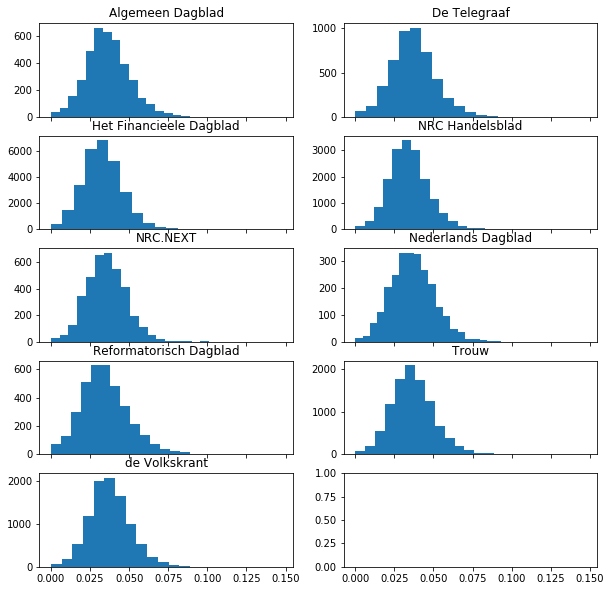

In [119]:
fig,axes = plt.subplots(nrows=5,ncols=2,figsize=(10,10),sharex=True)
grouped = new_df.groupby('MEDIUM')
for key,ax in zip(grouped.groups.keys(),axes.flatten()):
    ax.hist(grouped.get_group(key)['neg'],bins=20)
    ax.set_title(key)

In [11]:
medium_map = {'NRC Handelsblad': 'NRC Handelsblad',
 'Het Financieele Dagblad': 'Het Financieele Dagblad',
 'de Volkskrant': 'de Volkskrant',
 'De Telegraaf': 'De Telegraaf',
 'Algemeen Dagblad': 'Algemeen Dagblad',
 'NRC.NEXT': 'NRC.NEXT',
 'Reformatorisch Dagblad': 'Reformatorisch Dagblad',
 'Nederlands Dagblad': 'Nederlands Dagblad',
 'AD/Algemeen Dagblad': 'Algemeen Dagblad',
 'Metro (NL)': 'Metro',
 'Metro (Netherlands)': 'Metro',
 'Trouw' : 'Trouw'}
df['MEDIUM'] = df['MEDIUM'].map(medium_map)
df.to_csv('D:/Thesis/Sentiment/pltodata.csv')

In [15]:
df.to_csv('D:/Thesis/Sentiment/plotdata.csv')